In [15]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [16]:
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'
path3 = '../Data/car_dataset/GE_제네시스/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
for folder, subfolders, filenames in os.walk(path3):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  180588
Image_labels: 180588


In [12]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        if img[24] == 'P':
            continue
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])
            
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  98882
Image_labels: 98882


In [13]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211012_NI_071_18_WH_A_T_03_022.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
1,C_211012_NI_071_18_WH_A_T_02_005.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
2,C_211012_NI_071_18_WH_A_T_03_001.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
3,C_211012_NI_071_18_WH_A_T_02_010.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
4,C_211012_NI_071_18_WH_A_T_02_007.jpg,../Data/car_dataset/NI_닛산/071_알티마/2018_흰색_트림A,닛산/알티마/2018
...,...,...,...
98877,C_211129_JE_087_21_WH_A_T_02_002.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
98878,C_211129_JE_087_21_WH_A_T_02_005.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
98879,C_211129_JE_087_21_WH_A_T_03_008.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021
98880,C_211129_JE_087_21_WH_A_T_03_004.jpg,../Data/car_dataset/JE_지프/087_랭글러/2021_흰색_트림A,지프/랭글러/2021


In [14]:
train['label'].value_counts()

벤츠/E-Class/2017       1179
현대/코나/2018             937
기아/모닝/2017             911
기아/K3/2019             875
기아/스포티지/2018           851
                      ... 
쉐보레/말리부/2021            29
현대/벨로스터/2021            29
지프/랭글러/2018             29
BMW/X3/2020             27
미니/Countryman/2021      18
Name: label, Length: 370, dtype: int64

In [23]:
train['label'].value_counts().loc[lambda x : x > 900]

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
현대/코나/2020        940
기아/니로/2018        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [24]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

# for i, label in enumerate(train['label']):
#     #print(label)
#     if any(j in label for j in low_data) :
#         train.drop(i)
# train['label'].value_counts()

Index(['기아/K5/2021', '기아/K7/2021', '기아/K9/2017', '기아/K9/2018', '기아/니로/2021',
       '기아/레이/2021', '기아/모하비/2019', '기아/모하비/2020', '기아/모하비/2021',
       '기아/봉고3/2018', '기아/봉고3/2019', '기아/봉고3/2020', '기아/봉고3/2021',
       '기아/셀토스/2018', '기아/셀토스/2019', '기아/셀토스/2020', '기아/스토닉/2017',
       '기아/스토닉/2020', '기아/스토닉/2021', '기아/스팅어/2017', '기아/스팅어/2021',
       '기아/스포티지/2020', '기아/스포티지/2021', '기아/쏘울/2017', '기아/쏘울/2018',
       '기아/쏘울/2019', '기아/카니발/2021', '제네시스/EQ900/2019', '제네시스/G70/2020',
       '제네시스/G70/2021', '제네시스/G80/2020', '제네시스/G90/2020', '제네시스/G90/2021',
       '제네시스/GV80/2020', '제네시스/GV80/2021', '현대/i30/2017', '현대/i30/2018',
       '현대/i30/2019', '현대/넥쏘/2020', '현대/맥스크루즈/2017', '현대/맥스크루즈/2018',
       '현대/베뉴/2019', '현대/베뉴/2021', '현대/벨로스터/2017', '현대/벨로스터/2018',
       '현대/벨로스터/2019', '현대/벨로스터/2020', '현대/벨로스터/2021', '현대/스타렉스/2021',
       '현대/싼타페/2021', '현대/아이오닉/2017', '현대/아이오닉/2018', '현대/아이오닉/2019',
       '현대/아이오닉/2020', '현대/아이오닉/2021', '현대/엑센트/2017', '현대/엑센트/2018',
       '현대/엑센트/2019', 

In [25]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
...,...,...,...
148794,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148795,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148796,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148797,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018


In [26]:
train['label'].value_counts()

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
기아/니로/2018        940
현대/코나/2020        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [7]:
print(len(train.label))

206646


In [7]:
train.label.nunique()

134

In [27]:
label_value = train['label'].values
label_value

array(['현대/베뉴/2020', '현대/베뉴/2020', '현대/베뉴/2020', ..., '제네시스/G70/2018',
       '제네시스/G70/2018', '제네시스/G70/2018'], dtype=object)

In [28]:
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
...,...,...,...
148794,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148795,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148796,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148797,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53


In [29]:
le.classes_

array(['기아/K3/2017', '기아/K3/2018', '기아/K3/2019', '기아/K3/2020',
       '기아/K3/2021', '기아/K5/2017', '기아/K5/2018', '기아/K5/2019',
       '기아/K5/2020', '기아/K7/2017', '기아/K7/2018', '기아/K7/2019',
       '기아/K7/2020', '기아/K9/2019', '기아/K9/2020', '기아/K9/2021',
       '기아/니로/2017', '기아/니로/2018', '기아/니로/2019', '기아/니로/2020',
       '기아/레이/2017', '기아/레이/2018', '기아/레이/2019', '기아/레이/2020',
       '기아/모닝/2017', '기아/모닝/2018', '기아/모닝/2019', '기아/모닝/2020',
       '기아/모닝/2021', '기아/모하비/2017', '기아/모하비/2018', '기아/봉고3/2017',
       '기아/셀토스/2021', '기아/스토닉/2018', '기아/스토닉/2019', '기아/스팅어/2018',
       '기아/스팅어/2019', '기아/스팅어/2020', '기아/스포티지/2017', '기아/스포티지/2018',
       '기아/스포티지/2019', '기아/쏘렌토/2017', '기아/쏘렌토/2018', '기아/쏘렌토/2019',
       '기아/쏘렌토/2020', '기아/쏘렌토/2021', '기아/카니발/2017', '기아/카니발/2018',
       '기아/카니발/2019', '기아/카니발/2020', '제네시스/EQ900/2017', '제네시스/EQ900/2018',
       '제네시스/G70/2017', '제네시스/G70/2018', '제네시스/G70/2019', '제네시스/G80/2017',
       '제네시스/G80/2018', '제네시스/G80/2019', '제네시스/G80/2021', '제네시스/G90/2019

In [6]:
dist.destroy_process_group()

NameError: name 'dist' is not defined

In [30]:
project_name = 'preprocessed_ef_ns03_HK02'
user = 'hojunking'
run_name = 'preprocessed_ef_ns_03_HK02'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Training start with epoch 40 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
epoch 0 loss: 1.0838: 100%|█████████████████| 6544/6544 [26:34<00:00,  4.10it/s]

train accuracy = 0.43313
[[1107  252  109 ...    2    2    2]
 [ 335  729   88 ...    0    0    4]
 [ 105  167  615 ...    3    3    1]
 ...
 [   2    0    0 ... 1092  354    6]
 [   6    1    2 ...  570  783    4]
 [   0    0    1 ...    6    3 1749]]



epoch 0 loss: 1.1116: 100%|█████████████████| 1860/1860 [03:17<00:00,  9.40it/s]


validation accuracy = 0.55188
[[186  52  26 ...   0   0   0]
 [ 39 128  31 ...   0   0   0]
 [  2  25 281 ...   0   0   0]
 ...
 [  0   0   0 ...  98  30   0]
 [  0   0   0 ...  40 141   0]
 [  0   0   0 ...   0   0 211]]


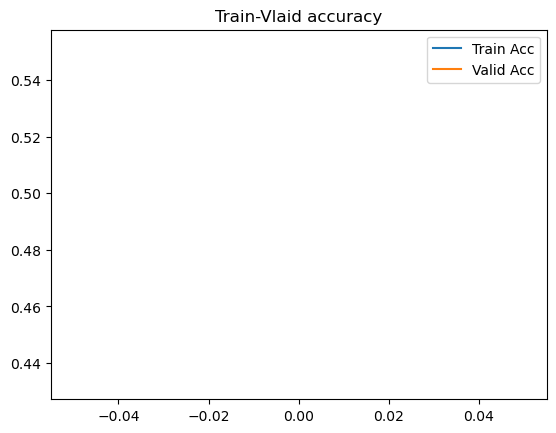

epoch 1 loss: 0.7011: 100%|█████████████████| 6544/6544 [25:32<00:00,  4.27it/s]

train accuracy = 0.68502
[[1678  188   95 ...    0    2    0]
 [ 253 1498   96 ...    1    1    0]
 [  66  142 1179 ...    0    0    0]
 ...
 [   1    0    0 ... 1713  242    0]
 [   0    1    0 ...  354 1478    1]
 [   0    0    0 ...    0    0 2118]]



epoch 1 loss: 0.9152: 100%|█████████████████| 1860/1860 [03:09<00:00,  9.81it/s]


validation accuracy = 0.64227
[[244  12  12 ...   0   0   0]
 [ 42 165   4 ...   0   0   0]
 [  9  47 229 ...   0   0   0]
 ...
 [  0   0   0 ... 133  29   0]
 [  0   0   0 ...  45 156   0]
 [  0   0   0 ...   0   0 212]]


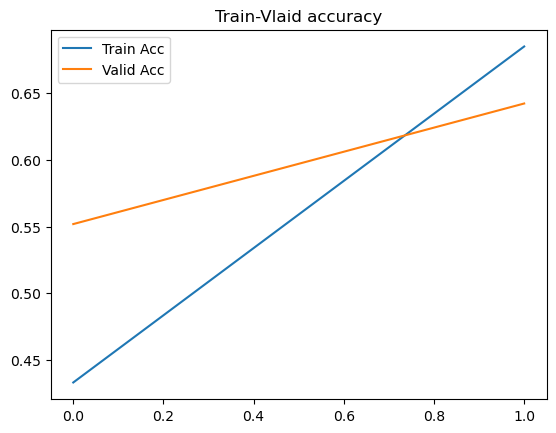

epoch 2 loss: 0.5273: 100%|█████████████████| 6544/6544 [25:19<00:00,  4.31it/s]

train accuracy = 0.78867
[[1884  133   58 ...    1    0    0]
 [ 146 1777   99 ...    0    2    0]
 [  52  148 1501 ...    0    2    0]
 ...
 [   0    0    0 ... 1906  168    0]
 [   0    0    0 ...  195 1826    0]
 [   0    0    0 ...    0    0 2159]]



epoch 2 loss: 0.8234: 100%|█████████████████| 1860/1860 [03:08<00:00,  9.84it/s]


validation accuracy = 0.69751
[[235  37   7 ...   0   0   0]
 [ 13 189   8 ...   0   1   0]
 [ 11  39 303 ...   0   0   0]
 ...
 [  0   0   0 ... 149  23   0]
 [  0   0   0 ...  40 168   0]
 [  0   0   0 ...   0   0 215]]


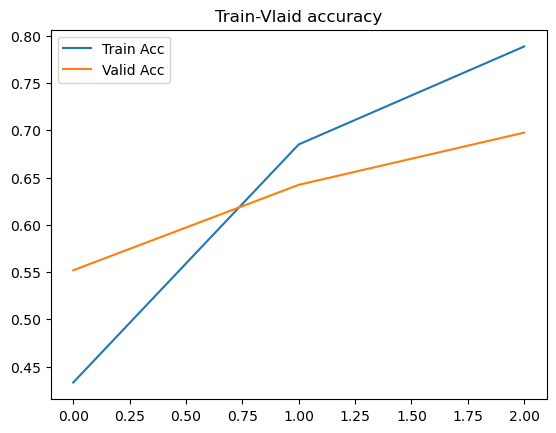

epoch 3 loss: 0.3848: 100%|█████████████████| 6544/6544 [25:09<00:00,  4.33it/s]

train accuracy = 0.85378
[[2001   72   39 ...    0    0    1]
 [  71 1936   78 ...    0    2    0]
 [  30  121 1664 ...    0    0    1]
 ...
 [   0    0    0 ... 2020   90    0]
 [   0    0    0 ...  120 1971    0]
 [   1    0    0 ...    0    0 2160]]



epoch 3 loss: 0.8020: 100%|█████████████████| 1860/1860 [03:08<00:00,  9.84it/s]


validation accuracy = 0.72362
[[257  14   8 ...   0   0   0]
 [ 23 178  25 ...   0   1   0]
 [ 14  42 346 ...   0   0   0]
 ...
 [  0   0   0 ... 138  24   0]
 [  0   0   0 ...  29 188   0]
 [  0   0   0 ...   0   0 208]]


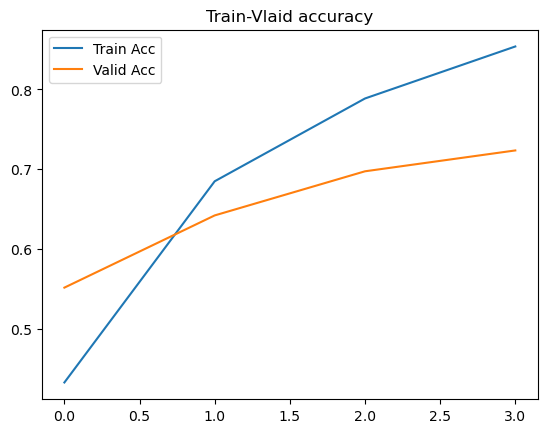

epoch 4 loss: 0.2940: 100%|█████████████████| 6544/6544 [25:09<00:00,  4.33it/s]


train accuracy = 0.89193
[[2072   47   31 ...    0    0    0]
 [  52 2019   56 ...    0    0    0]
 [  27   88 1794 ...    0    0    0]
 ...
 [   0    0    0 ... 2089   63    0]
 [   0    0    1 ...   77 2051    0]
 [   0    0    0 ...    0    0 2180]]


epoch 4 loss: 0.7921: 100%|█████████████████| 1860/1860 [03:08<00:00,  9.85it/s]


validation accuracy = 0.74630
[[253  15   7 ...   0   0   0]
 [ 16 189  14 ...   0   0   0]
 [  5  41 323 ...   0   0   0]
 ...
 [  0   0   0 ... 148  17   1]
 [  0   0   0 ...  29 170   0]
 [  0   0   0 ...   0   0 210]]


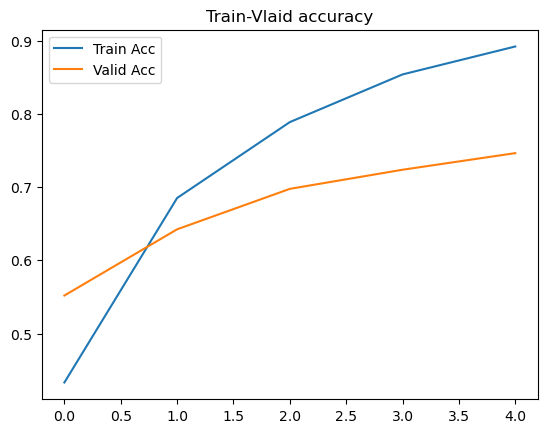

epoch 5 loss: 0.2254: 100%|█████████████████| 6544/6544 [25:13<00:00,  4.32it/s]


train accuracy = 0.91562
[[2095   41   20 ...    0    0    0]
 [  38 2043   55 ...    0    0    0]
 [  15   98 1898 ...    0    0    0]
 ...
 [   0    0    0 ... 2116   45    0]
 [   0    0    1 ...   61 2085    0]
 [   0    0    0 ...    1    0 2178]]


epoch 5 loss: 0.7887: 100%|█████████████████| 1860/1860 [03:09<00:00,  9.81it/s]


validation accuracy = 0.75605
[[278   2   7 ...   0   0   0]
 [ 21 197  18 ...   0   1   0]
 [ 11  48 321 ...   0   0   0]
 ...
 [  0   0   0 ... 130   8   0]
 [  0   0   0 ...  22 149   0]
 [  0   0   0 ...   0   0 212]]


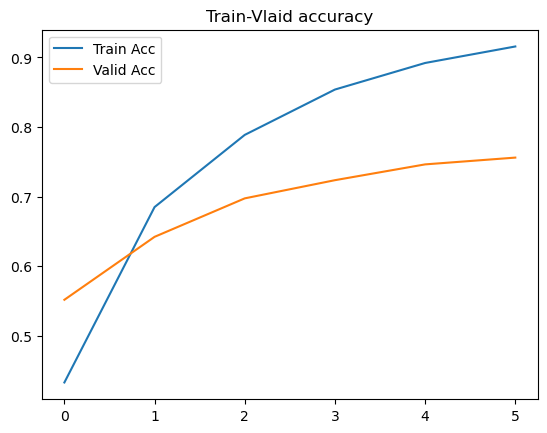

epoch 6 loss: 0.2173: 100%|█████████████████| 6544/6544 [25:16<00:00,  4.32it/s]

train accuracy = 0.93163
[[2119   33   22 ...    0    0    0]
 [  29 2067   62 ...    0    0    0]
 [  17   77 1911 ...    0    1    0]
 ...
 [   0    0    1 ... 2131   42    0]
 [   1    0    0 ...   45 2115    0]
 [   0    0    0 ...    0    1 2185]]



epoch 6 loss: 0.7955: 100%|█████████████████| 1860/1860 [03:10<00:00,  9.78it/s]


validation accuracy = 0.76589
[[266   8  10 ...   0   0   0]
 [  8 208  10 ...   0   1   0]
 [  8  45 347 ...   0   0   0]
 ...
 [  0   0   0 ... 162   5   0]
 [  0   0   0 ...  31 168   0]
 [  0   0   0 ...   0   0 216]]


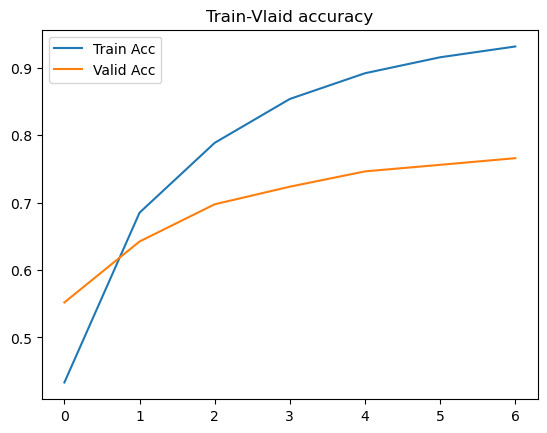

epoch 7 loss: 0.1892: 100%|█████████████████| 6544/6544 [25:26<00:00,  4.29it/s]


train accuracy = 0.94291
[[2139   21   14 ...    0    0    0]
 [  26 2090   49 ...    1    0    0]
 [  12   72 1961 ...    0    0    0]
 ...
 [   0    0    0 ... 2142   35    0]
 [   0    0    0 ...   36 2129    0]
 [   0    0    0 ...    0    0 2190]]


epoch 7 loss: 0.8347: 100%|█████████████████| 1860/1860 [03:10<00:00,  9.75it/s]


validation accuracy = 0.76774
[[274   3   2 ...   0   0   0]
 [ 22 189   8 ...   0   1   0]
 [ 14  47 336 ...   0   0   0]
 ...
 [  0   0   0 ... 155  10   0]
 [  0   0   0 ...  28 168   0]
 [  0   0   0 ...   0   0 217]]


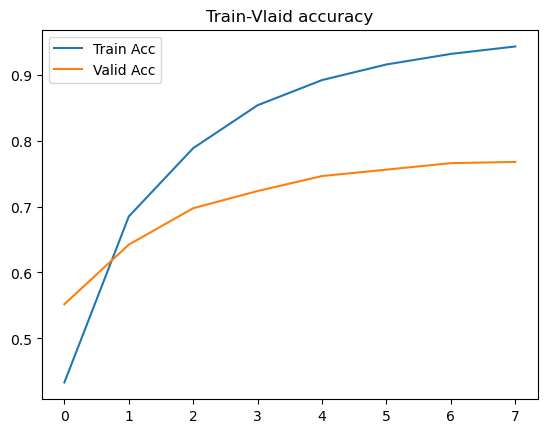

epoch 8 loss: 0.1514: 100%|█████████████████| 6544/6544 [25:28<00:00,  4.28it/s]


train accuracy = 0.95122
[[2141   21   10 ...    0    0    0]
 [  21 2114   42 ...    0    0    0]
 [  10   54 2022 ...    0    1    0]
 ...
 [   0    0    0 ... 2152   28    0]
 [   0    0    0 ...   27 2139    0]
 [   0    0    0 ...    0    0 2187]]


epoch 8 loss: 0.8181: 100%|█████████████████| 1860/1860 [03:10<00:00,  9.76it/s]


validation accuracy = 0.77907
[[270   8   3 ...   0   0   0]
 [ 10 207  10 ...   0   1   0]
 [  8  47 349 ...   0   0   0]
 ...
 [  0   0   0 ... 147  15   0]
 [  0   0   0 ...  21 183   0]
 [  0   0   0 ...   0   0 219]]


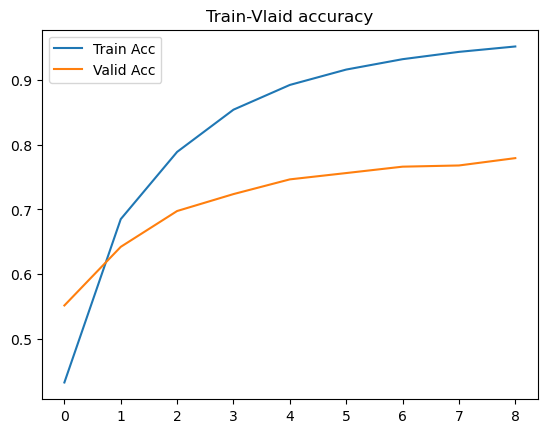

epoch 9 loss: 0.1368: 100%|█████████████████| 6544/6544 [25:17<00:00,  4.31it/s]

train accuracy = 0.95704
[[2153   18   11 ...    0    0    0]
 [  16 2118   37 ...    0    0    0]
 [  10   51 2032 ...    0    0    0]
 ...
 [   0    0    0 ... 2141   31    0]
 [   0    0    0 ...   35 2142    0]
 [   0    0    0 ...    0    0 2199]]



epoch 9 loss: 0.8449: 100%|█████████████████| 1860/1860 [03:10<00:00,  9.78it/s]


validation accuracy = 0.78209
[[255  18   9 ...   0   0   0]
 [  5 205  24 ...   0   1   0]
 [  4  38 367 ...   0   0   0]
 ...
 [  0   0   0 ... 145  12   0]
 [  0   0   0 ...  29 162   0]
 [  0   0   0 ...   0   0 216]]


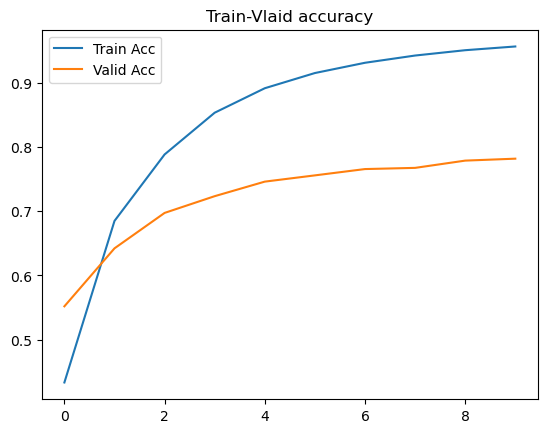

epoch 10 loss: 0.1123: 100%|████████████████| 6544/6544 [25:18<00:00,  4.31it/s]

train accuracy = 0.96215
[[2158   15    8 ...    0    0    0]
 [  16 2134   31 ...    0    0    0]
 [   5   37 2064 ...    0    0    0]
 ...
 [   0    0    0 ... 2168   20    0]
 [   0    0    0 ...   21 2146    0]
 [   0    0    0 ...    0    0 2191]]



epoch 10 loss: 0.8717: 100%|████████████████| 1860/1860 [03:10<00:00,  9.77it/s]


validation accuracy = 0.78337
[[274   9   2 ...   0   0   0]
 [ 10 200  22 ...   0   1   0]
 [  7  46 350 ...   0   0   0]
 ...
 [  0   0   0 ... 155  13   0]
 [  0   0   0 ...  25 177   0]
 [  0   0   0 ...   0   0 215]]


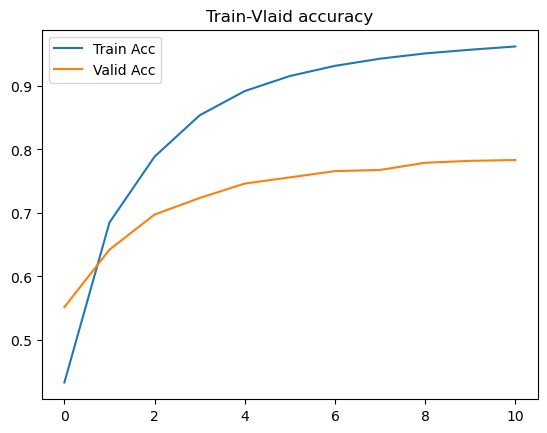

epoch 11 loss: 0.1233: 100%|████████████████| 6544/6544 [25:15<00:00,  4.32it/s]

train accuracy = 0.96566
[[2166   14    6 ...    0    0    0]
 [  16 2136   29 ...    0    0    0]
 [  11   42 2071 ...    0    0    0]
 ...
 [   0    0    0 ... 2168   21    0]
 [   0    0    0 ...   23 2147    0]
 [   0    0    0 ...    0    0 2194]]



epoch 11 loss: 0.8574: 100%|████████████████| 1860/1860 [03:10<00:00,  9.74it/s]


validation accuracy = 0.78928
[[275   7   6 ...   0   0   0]
 [ 11 214  20 ...   0   1   0]
 [  6  45 373 ...   0   0   0]
 ...
 [  0   0   0 ... 153  10   0]
 [  0   0   0 ...  21 182   0]
 [  0   0   0 ...   0   0 215]]


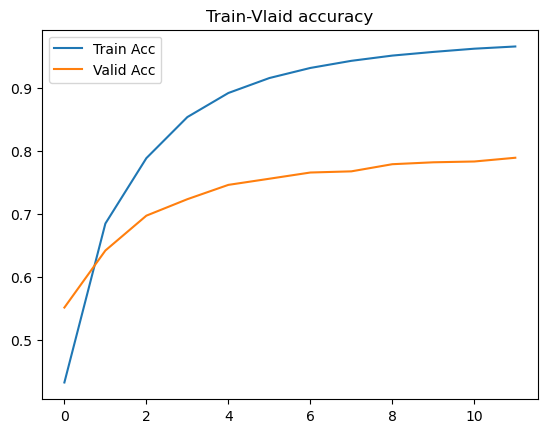

epoch 12 loss: 0.1035: 100%|████████████████| 6544/6544 [25:23<00:00,  4.29it/s]


train accuracy = 0.96794
[[2167   17    6 ...    0    0    0]
 [  18 2138   25 ...    0    0    0]
 [   6   28 2073 ...    0    0    0]
 ...
 [   0    0    0 ... 2165   14    0]
 [   0    0    0 ...   22 2165    0]
 [   0    0    0 ...    0    0 2194]]


epoch 12 loss: 0.8129: 100%|████████████████| 1860/1860 [03:11<00:00,  9.70it/s]


validation accuracy = 0.79735
[[268  19   4 ...   0   0   0]
 [  4 219  19 ...   0   1   0]
 [  7  43 391 ...   0   0   0]
 ...
 [  0   0   0 ... 161  12   0]
 [  0   0   0 ...  16 185   0]
 [  0   0   0 ...   0   0 216]]


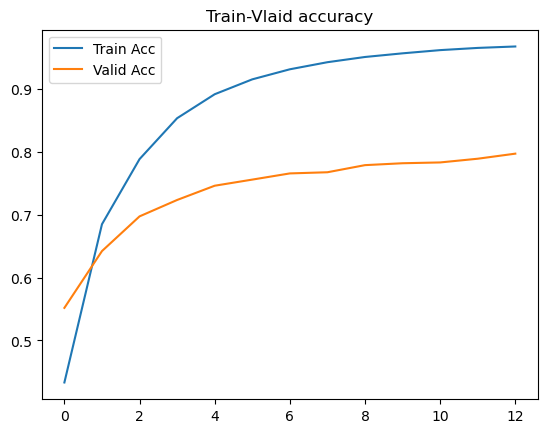

epoch 13 loss: 0.1071: 100%|████████████████| 6544/6544 [25:22<00:00,  4.30it/s]

train accuracy = 0.97178
[[2174   11    5 ...    0    0    0]
 [  10 2149   19 ...    0    0    0]
 [   5   35 2095 ...    0    0    0]
 ...
 [   0    0    0 ... 2166   19    0]
 [   0    0    0 ...   22 2161    0]
 [   0    0    0 ...    0    0 2190]]



epoch 13 loss: 0.8125: 100%|████████████████| 1860/1860 [03:12<00:00,  9.66it/s]


validation accuracy = 0.80349
[[274   6   8 ...   0   0   0]
 [  7 226  13 ...   0   1   0]
 [  1  51 359 ...   0   0   0]
 ...
 [  0   0   0 ... 152  17   0]
 [  0   0   0 ...  15 188   0]
 [  0   0   0 ...   0   0 209]]


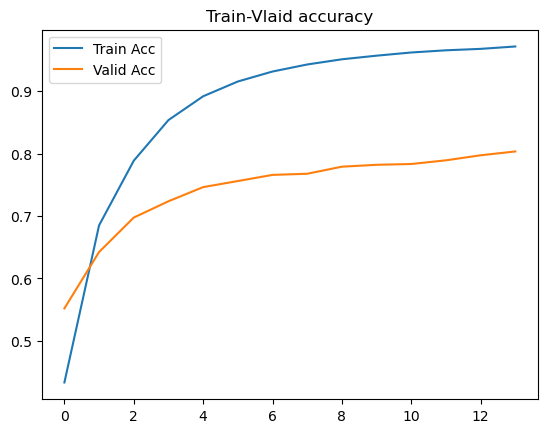

epoch 14 loss: 0.0976: 100%|████████████████| 6544/6544 [25:28<00:00,  4.28it/s]

train accuracy = 0.97325
[[2175   12    6 ...    0    0    0]
 [  13 2150   17 ...    0    0    0]
 [   8   17 2103 ...    0    0    0]
 ...
 [   0    0    0 ... 2166   25    0]
 [   0    0    0 ...   24 2161    0]
 [   0    0    0 ...    0    0 2197]]



epoch 14 loss: 0.8389: 100%|████████████████| 1860/1860 [03:12<00:00,  9.66it/s]


validation accuracy = 0.80228
[[280   1   7 ...   0   0   0]
 [ 11 202  22 ...   0   1   0]
 [  6  41 388 ...   0   0   0]
 ...
 [  0   0   0 ... 151  22   0]
 [  0   0   0 ...  11 206   0]
 [  0   0   0 ...   0   0 212]]


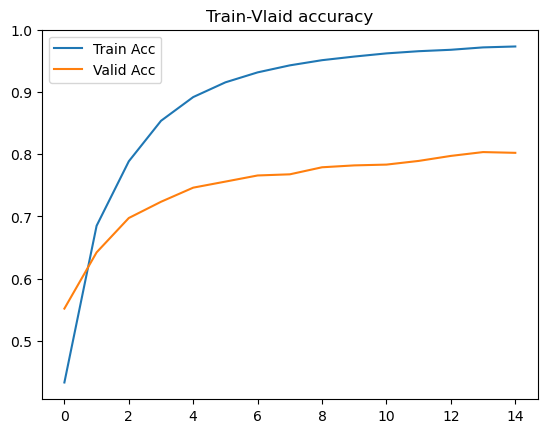

epoch 15 loss: 0.1035: 100%|████████████████| 6544/6544 [25:28<00:00,  4.28it/s]

train accuracy = 0.97530
[[2179    6    6 ...    1    0    1]
 [   8 2156   26 ...    0    0    0]
 [   0   33 2106 ...    0    0    0]
 ...
 [   0    0    0 ... 2174   16    0]
 [   0    0    0 ...   16 2163    0]
 [   0    0    0 ...    0    0 2196]]



epoch 15 loss: 0.8933: 100%|████████████████| 1860/1860 [03:13<00:00,  9.60it/s]


validation accuracy = 0.79157
[[271   9   3 ...   0   0   0]
 [  6 210  25 ...   0   1   0]
 [  8  34 378 ...   0   1   0]
 ...
 [  0   0   0 ... 167   6   0]
 [  0   0   0 ...  25 185   0]
 [  0   0   0 ...   0   0 212]]


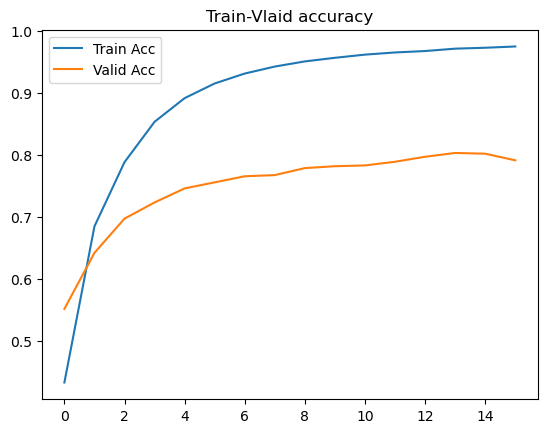

epoch 16 loss: 0.0865: 100%|████████████████| 6544/6544 [25:25<00:00,  4.29it/s]

train accuracy = 0.97711
[[2176   10    6 ...    0    0    0]
 [   9 2166   21 ...    0    0    0]
 [   4   24 2098 ...    0    0    0]
 ...
 [   0    0    0 ... 2179   14    0]
 [   0    0    0 ...   20 2168    0]
 [   0    0    0 ...    0    0 2194]]



epoch 16 loss: 0.9018: 100%|████████████████| 1860/1860 [03:14<00:00,  9.56it/s]


validation accuracy = 0.79765
[[274   8   5 ...   0   0   0]
 [  9 218  15 ...   0   1   0]
 [  1  51 365 ...   0   0   0]
 ...
 [  0   0   0 ... 160  13   0]
 [  0   0   0 ...  21 182   0]
 [  0   0   0 ...   0   0 212]]


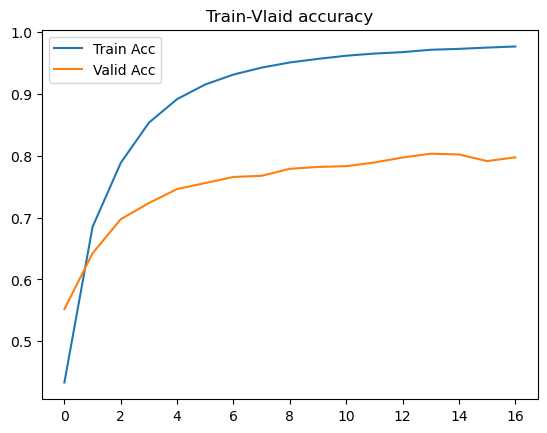

epoch 17 loss: 0.0713: 100%|████████████████| 6544/6544 [25:29<00:00,  4.28it/s]

train accuracy = 0.97781
[[2180    7    3 ...    0    0    0]
 [   6 2163   14 ...    0    0    0]
 [   3   20 2124 ...    0    0    0]
 ...
 [   0    0    0 ... 2173   15    0]
 [   1    0    0 ...   14 2172    0]
 [   0    0    0 ...    0    0 2193]]



epoch 17 loss: 0.8885: 100%|████████████████| 1860/1860 [03:15<00:00,  9.52it/s]


validation accuracy = 0.80316
[[276   2   8 ...   0   0   0]
 [ 13 201  20 ...   0   1   0]
 [  2  40 375 ...   0   0   0]
 ...
 [  0   0   0 ... 163   6   0]
 [  0   0   0 ...  23 178   0]
 [  0   0   0 ...   0   0 216]]


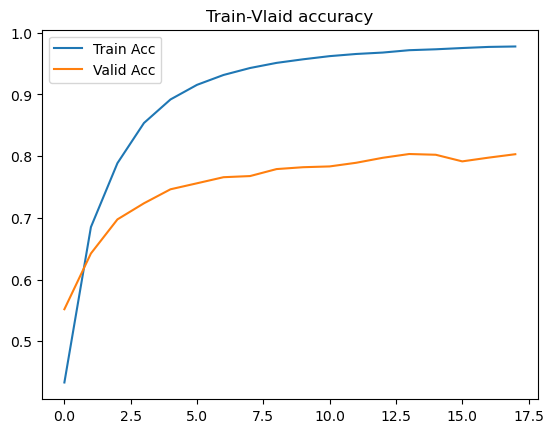

epoch 18 loss: 0.0911: 100%|████████████████| 6544/6544 [25:24<00:00,  4.29it/s]


train accuracy = 0.97921
[[2178    9    4 ...    0    0    0]
 [  11 2163   19 ...    0    0    0]
 [   3   24 2114 ...    0    0    0]
 ...
 [   0    0    0 ... 2182    8    0]
 [   0    0    0 ...   12 2171    0]
 [   0    0    0 ...    0    0 2195]]


epoch 18 loss: 0.8919: 100%|████████████████| 1860/1860 [03:16<00:00,  9.45it/s]


validation accuracy = 0.80729
[[277   4   4 ...   0   0   0]
 [ 11 212  25 ...   0   1   0]
 [  4  43 384 ...   0   0   0]
 ...
 [  0   0   0 ... 151  17   0]
 [  0   0   0 ...  12 188   0]
 [  0   0   0 ...   0   0 210]]


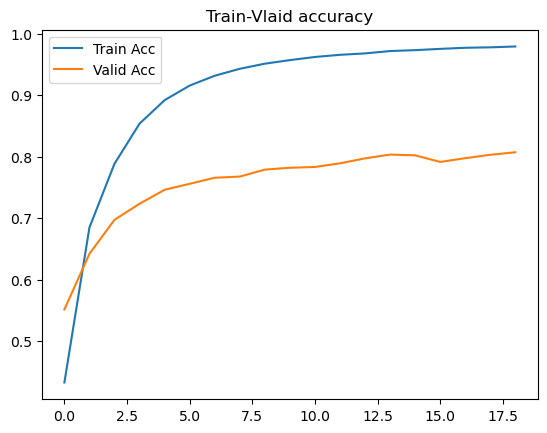

epoch 19 loss: 0.1031: 100%|████████████████| 6544/6544 [25:33<00:00,  4.27it/s]

train accuracy = 0.98015
[[2177   12    0 ...    0    0    0]
 [   8 2163   20 ...    0    0    0]
 [   3   18 2135 ...    0    0    0]
 ...
 [   0    0    0 ... 2178   11    0]
 [   0    0    0 ...    9 2176    0]
 [   0    0    0 ...    0    0 2196]]



epoch 19 loss: 0.8665: 100%|████████████████| 1860/1860 [03:18<00:00,  9.35it/s]


validation accuracy = 0.80917
[[275   8   5 ...   0   0   0]
 [ 11 211  15 ...   0   1   0]
 [  2  45 391 ...   0   0   0]
 ...
 [  0   0   0 ... 148  20   0]
 [  0   0   0 ...   9 197   0]
 [  0   0   0 ...   0   0 210]]


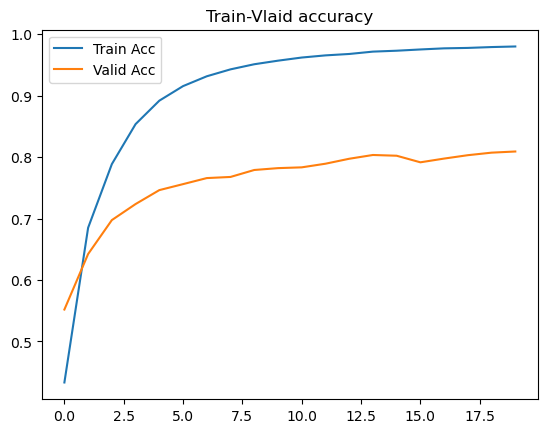

epoch 20 loss: 0.0601: 100%|████████████████| 6544/6544 [25:47<00:00,  4.23it/s]


train accuracy = 0.98154
[[2177    5    8 ...    0    0    0]
 [   4 2171   16 ...    0    0    0]
 [   2   24 2114 ...    0    1    0]
 ...
 [   0    0    0 ... 2172   14    0]
 [   0    0    0 ...   13 2176    0]
 [   0    0    0 ...    0    0 2199]]


epoch 20 loss: 0.9040: 100%|████████████████| 1860/1860 [03:21<00:00,  9.23it/s]


validation accuracy = 0.80685
[[271   6   8 ...   0   0   0]
 [ 10 207  25 ...   0   1   0]
 [  6  35 393 ...   0   0   0]
 ...
 [  0   0   0 ... 160  12   0]
 [  0   0   0 ...  17 192   0]
 [  0   0   0 ...   0   0 213]]


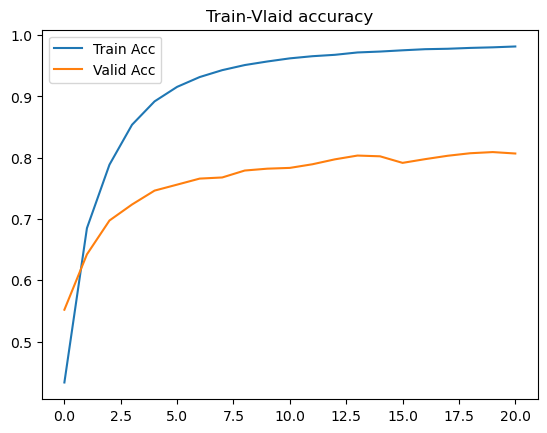

epoch 21 loss: 0.0881: 100%|████████████████| 6544/6544 [25:42<00:00,  4.24it/s]

train accuracy = 0.98231
[[2179    7    4 ...    0    0    0]
 [   5 2173   16 ...    0    0    0]
 [   3   25 2134 ...    1    0    0]
 ...
 [   0    0    0 ... 2181   13    0]
 [   0    0    0 ...    9 2179    0]
 [   0    0    0 ...    0    0 2196]]



epoch 21 loss: 0.8982: 100%|████████████████| 1860/1860 [03:19<00:00,  9.31it/s]


validation accuracy = 0.80937
[[274   4   5 ...   0   0   0]
 [  8 207  26 ...   0   1   0]
 [  8  28 391 ...   0   0   0]
 ...
 [  0   0   0 ... 158  11   0]
 [  0   0   0 ...  23 182   0]
 [  0   0   0 ...   0   0 207]]


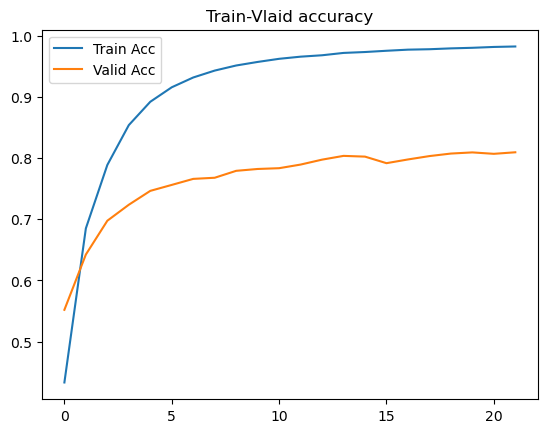

epoch 22 loss: 0.0746: 100%|████████████████| 6544/6544 [25:40<00:00,  4.25it/s]


train accuracy = 0.98298
[[2175   15    3 ...    0    0    1]
 [  12 2165    8 ...    0    0    0]
 [   6   15 2138 ...    0    0    0]
 ...
 [   0    0    0 ... 2181   12    0]
 [   0    1    0 ...   16 2181    0]
 [   0    0    0 ...    0    0 2193]]


epoch 22 loss: 0.9026: 100%|████████████████| 1860/1860 [03:19<00:00,  9.31it/s]


validation accuracy = 0.80874
[[281   3   9 ...   0   0   0]
 [ 11 219  21 ...   0   1   0]
 [  1  42 385 ...   1   0   0]
 ...
 [  0   0   0 ... 173   4   0]
 [  0   0   0 ...  27 177   0]
 [  0   0   0 ...   0   0 214]]


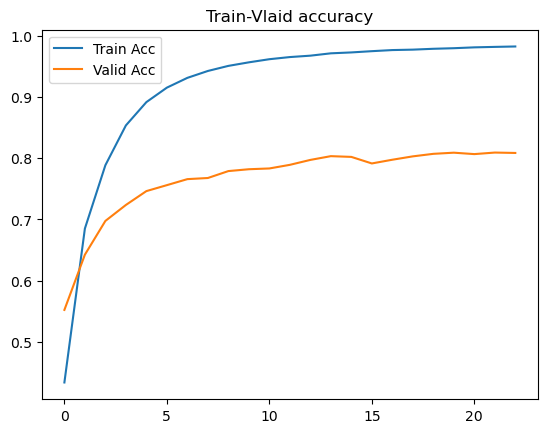

epoch 23 loss: 0.0638: 100%|████████████████| 6544/6544 [25:35<00:00,  4.26it/s]


train accuracy = 0.98333
[[2177    6    4 ...    0    0    0]
 [   6 2176   14 ...    0    0    0]
 [   3   16 2134 ...    0    0    0]
 ...
 [   0    0    0 ... 2174   14    0]
 [   0    0    0 ...   12 2174    0]
 [   0    0    0 ...    0    0 2192]]


epoch 23 loss: 0.8977: 100%|████████████████| 1860/1860 [03:20<00:00,  9.28it/s]


validation accuracy = 0.81213
[[288   3   4 ...   0   0   0]
 [ 10 224  15 ...   0   1   0]
 [  4  44 406 ...   0   0   0]
 ...
 [  0   0   0 ... 164   8   0]
 [  0   0   0 ...  18 185   1]
 [  0   0   0 ...   0   0 214]]


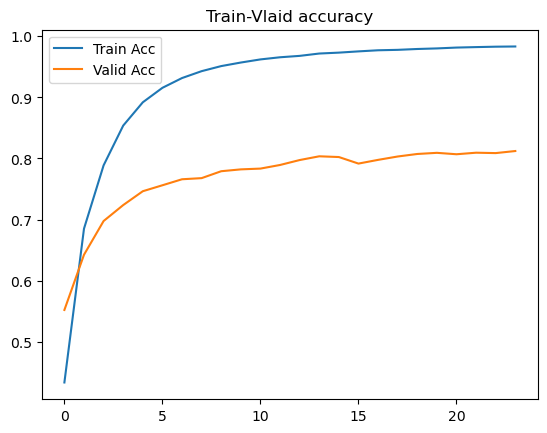

epoch 24 loss: 0.0638: 100%|████████████████| 6544/6544 [25:33<00:00,  4.27it/s]

train accuracy = 0.98376
[[2177   10    4 ...    0    0    0]
 [   9 2177    6 ...    0    0    0]
 [   4    8 2149 ...    0    0    0]
 ...
 [   0    0    0 ... 2186   10    0]
 [   0    0    0 ...   13 2183    0]
 [   0    0    0 ...    0    0 2197]]



epoch 24 loss: 0.9421: 100%|████████████████| 1860/1860 [03:20<00:00,  9.30it/s]


validation accuracy = 0.80598
[[258  24   6 ...   0   0   0]
 [  4 227   9 ...   0   1   0]
 [ 12  65 342 ...   0   0   0]
 ...
 [  0   0   0 ... 156   7   0]
 [  0   0   0 ...  12 181   0]
 [  0   0   0 ...   0   0 215]]


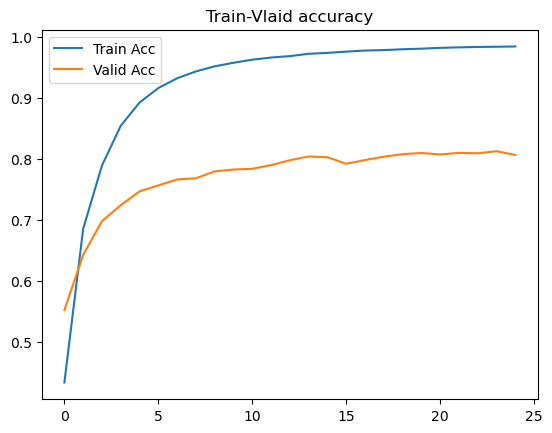

epoch 25 loss: 0.0481: 100%|████████████████| 6544/6544 [25:45<00:00,  4.23it/s]

train accuracy = 0.99136
[[2190    5    1 ...    0    0    0]
 [   4 2178   16 ...    0    0    0]
 [   5   12 2160 ...    0    0    0]
 ...
 [   0    0    0 ... 2193    8    0]
 [   0    0    0 ...    6 2192    0]
 [   0    0    0 ...    0    0 2200]]



epoch 25 loss: 0.8430: 100%|████████████████| 1860/1860 [03:19<00:00,  9.33it/s]


validation accuracy = 0.83028
[[272  11   6 ...   0   0   0]
 [  3 233  13 ...   0   1   0]
 [  2  50 385 ...   0   1   0]
 ...
 [  0   0   0 ... 169   6   0]
 [  0   0   1 ...  18 186   0]
 [  0   0   0 ...   0   0 218]]


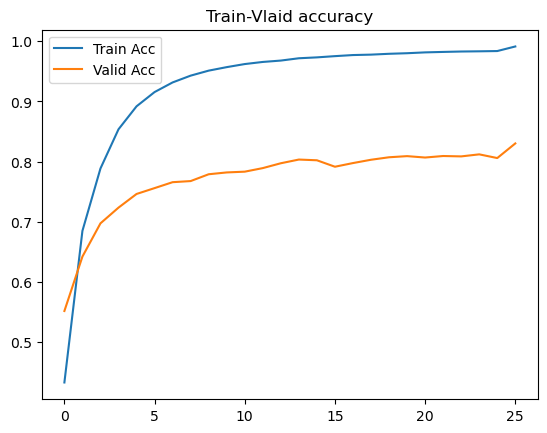

epoch 26 loss: 0.0399: 100%|████████████████| 6544/6544 [25:34<00:00,  4.27it/s]


train accuracy = 0.99317
[[2195    3    1 ...    0    0    0]
 [   2 2191    6 ...    0    0    0]
 [   1   10 2171 ...    0    0    0]
 ...
 [   0    0    0 ... 2197    3    0]
 [   0    0    0 ...    4 2194    0]
 [   0    0    0 ...    0    0 2201]]


epoch 26 loss: 0.8734: 100%|████████████████| 1860/1860 [03:19<00:00,  9.31it/s]


validation accuracy = 0.83061
[[273  13   5 ...   0   0   0]
 [  2 221  22 ...   0   1   0]
 [  0  38 389 ...   0   0   0]
 ...
 [  0   0   0 ... 167   6   0]
 [  0   0   1 ...  16 185   0]
 [  0   0   0 ...   0   0 210]]


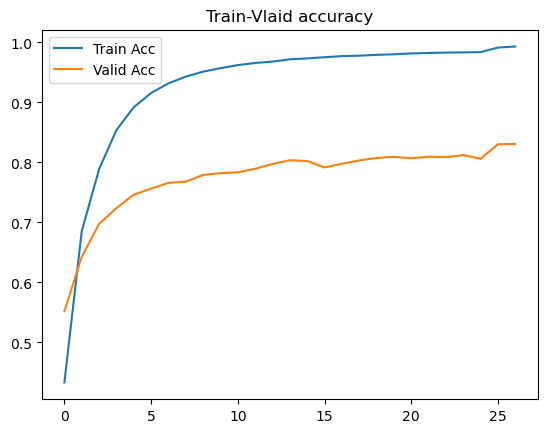

epoch 27 loss: 0.0265: 100%|████████████████| 6544/6544 [25:37<00:00,  4.26it/s]


train accuracy = 0.99364
[[2196    2    3 ...    0    0    0]
 [   3 2188    5 ...    0    0    0]
 [   0    6 2176 ...    0    0    0]
 ...
 [   0    0    0 ... 2196    3    0]
 [   0    0    0 ...    4 2194    0]
 [   0    0    0 ...    0    0 2202]]


epoch 27 loss: 0.8810: 100%|████████████████| 1860/1860 [03:20<00:00,  9.27it/s]


validation accuracy = 0.82779
[[279   8   5 ...   0   0   0]
 [  8 205  30 ...   0   1   0]
 [  5  33 400 ...   0   0   0]
 ...
 [  0   0   0 ... 166   7   0]
 [  0   0   0 ...  20 189   0]
 [  0   0   0 ...   0   0 208]]


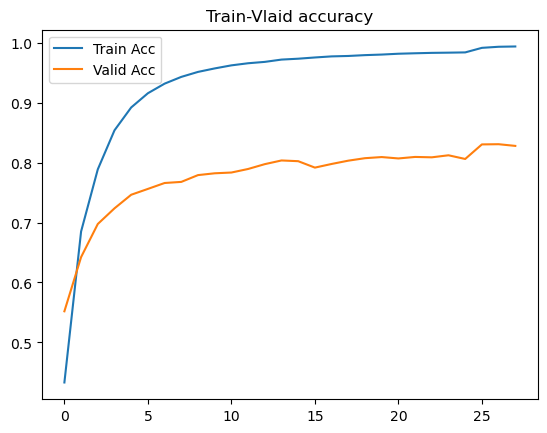

epoch 28 loss: 0.0336: 100%|████████████████| 6544/6544 [25:41<00:00,  4.25it/s]

train accuracy = 0.99424
[[2197    2    1 ...    0    0    0]
 [   2 2192    6 ...    0    0    0]
 [   3    4 2184 ...    0    0    0]
 ...
 [   0    0    0 ... 2197    1    0]
 [   0    0    0 ...    4 2196    0]
 [   0    0    0 ...    0    0 2202]]



epoch 28 loss: 0.9157: 100%|████████████████| 1860/1860 [03:19<00:00,  9.33it/s]


validation accuracy = 0.82866
[[279   9   4 ...   0   0   0]
 [  3 217  28 ...   0   1   0]
 [  1  37 392 ...   0   0   0]
 ...
 [  0   0   0 ... 161   9   0]
 [  1   0   1 ...  19 179   0]
 [  0   0   0 ...   0   0 210]]


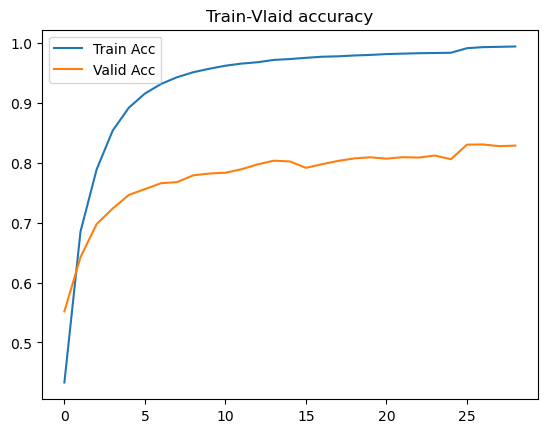

epoch 29 loss: 0.0472: 100%|████████████████| 6544/6544 [25:42<00:00,  4.24it/s]

train accuracy = 0.99433
[[2199    2    2 ...    0    0    0]
 [   4 2187    6 ...    0    0    0]
 [   2    7 2181 ...    0    0    0]
 ...
 [   0    0    0 ... 2196    4    0]
 [   0    0    0 ...    6 2195    0]
 [   0    0    0 ...    0    0 2203]]



epoch 29 loss: 0.9198: 100%|████████████████| 1860/1860 [03:21<00:00,  9.24it/s]


validation accuracy = 0.82853
[[276   6   6 ...   0   0   0]
 [  8 207  26 ...   0   1   0]
 [  2  39 386 ...   0   1   0]
 ...
 [  0   0   0 ... 163   8   0]
 [  0   0   0 ...  17 189   1]
 [  0   0   0 ...   0   0 215]]


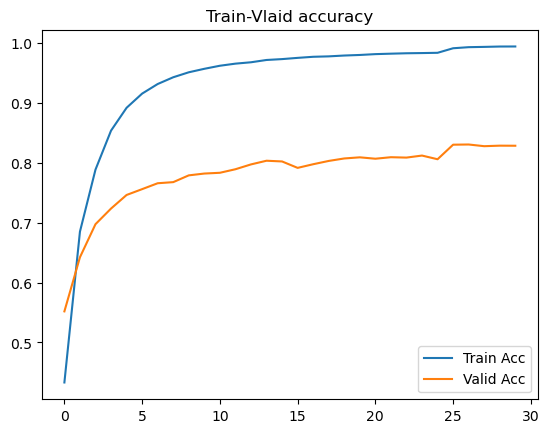

epoch 30 loss: 0.0228: 100%|████████████████| 6544/6544 [25:40<00:00,  4.25it/s]

train accuracy = 0.99469
[[2197    2    1 ...    0    0    0]
 [   1 2199    2 ...    0    1    0]
 [   1    3 2183 ...    0    0    0]
 ...
 [   0    0    0 ... 2197    3    0]
 [   0    0    0 ...    4 2193    0]
 [   0    0    0 ...    0    0 2204]]



epoch 30 loss: 0.9178: 100%|████████████████| 1860/1860 [03:20<00:00,  9.28it/s]


validation accuracy = 0.82970
[[283   6   5 ...   0   0   0]
 [  5 230  15 ...   0   1   0]
 [  3  50 383 ...   0   0   0]
 ...
 [  0   0   0 ... 158  12   0]
 [  0   0   0 ...  15 192   0]
 [  0   0   0 ...   0   0 215]]


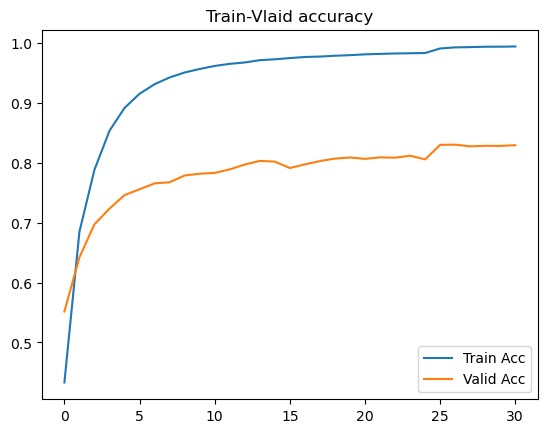

epoch 31 loss: 0.0512: 100%|████████████████| 6544/6544 [25:51<00:00,  4.22it/s]


train accuracy = 0.99476
[[2195    3    0 ...    0    0    0]
 [   4 2187    6 ...    0    0    0]
 [   0    5 2186 ...    0    0    0]
 ...
 [   0    0    0 ... 2199    0    0]
 [   0    0    0 ...    0 2199    0]
 [   0    0    0 ...    0    0 2204]]


epoch 31 loss: 0.9375: 100%|████████████████| 1860/1860 [03:18<00:00,  9.35it/s]


validation accuracy = 0.83001
[[277   7   5 ...   0   0   0]
 [  7 212  24 ...   0   1   0]
 [  3  36 417 ...   0   0   0]
 ...
 [  0   0   0 ... 170   6   0]
 [  0   0   1 ...  24 174   0]
 [  0   0   0 ...   0   1 211]]


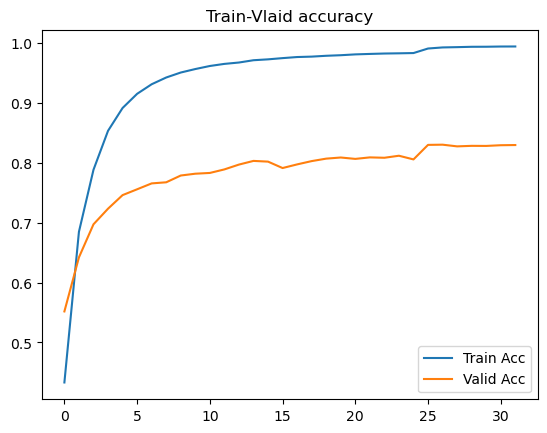

epoch 32 loss: 0.0284: 100%|████████████████| 6544/6544 [25:45<00:00,  4.23it/s]


train accuracy = 0.99529
[[2200    0    1 ...    0    0    0]
 [   0 2197    6 ...    0    0    0]
 [   0    5 2184 ...    0    0    0]
 ...
 [   0    0    0 ... 2200    1    0]
 [   0    0    0 ...    4 2196    0]
 [   0    0    0 ...    0    0 2204]]


epoch 32 loss: 0.9559: 100%|████████████████| 1860/1860 [03:19<00:00,  9.31it/s]


validation accuracy = 0.82950
[[276   5   5 ...   0   0   0]
 [  3 227  17 ...   0   1   0]
 [  1  46 407 ...   0   0   0]
 ...
 [  0   0   0 ... 162  13   0]
 [  0   0   0 ...  13 189   0]
 [  0   0   0 ...   0   0 213]]


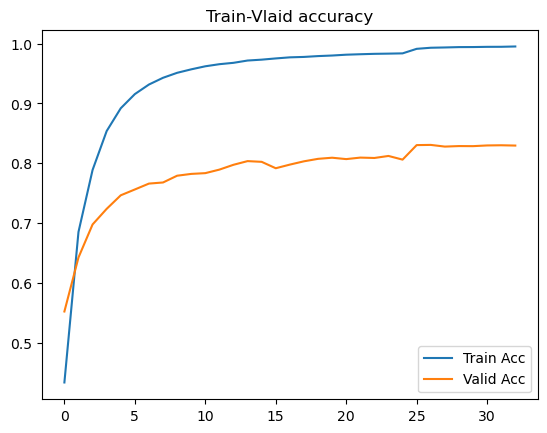

epoch 33 loss: 0.0452: 100%|████████████████| 6544/6544 [25:50<00:00,  4.22it/s]

train accuracy = 0.99521
[[2200    3    0 ...    0    0    0]
 [   3 2196    3 ...    0    0    0]
 [   2    5 2188 ...    0    0    0]
 ...
 [   0    0    0 ... 2193    4    1]
 [   0    0    0 ...    3 2196    0]
 [   0    0    0 ...    0    0 2202]]



epoch 33 loss: 0.9795: 100%|████████████████| 1860/1860 [03:20<00:00,  9.29it/s]


validation accuracy = 0.82927
[[259  14  14 ...   0   0   0]
 [  3 224  16 ...   0   1   0]
 [  0  36 396 ...   0   0   0]
 ...
 [  0   0   0 ... 154  13   0]
 [  0   0   1 ...  13 189   0]
 [  0   0   0 ...   0   0 214]]


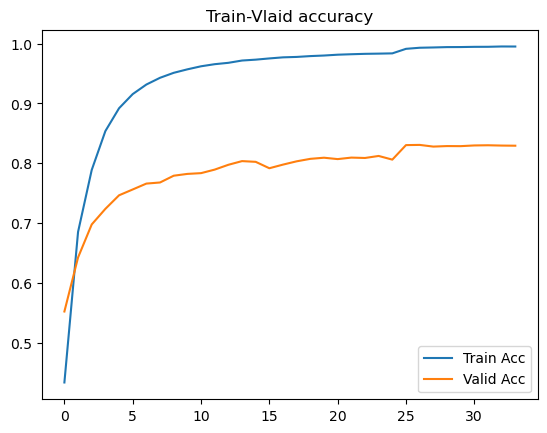

epoch 34 loss: 0.0378: 100%|████████████████| 6544/6544 [25:54<00:00,  4.21it/s]

train accuracy = 0.99531
[[2199    2    2 ...    0    0    0]
 [   1 2191    8 ...    0    0    0]
 [   1    5 2178 ...    0    1    0]
 ...
 [   0    0    0 ... 2200    1    0]
 [   0    0    0 ...    2 2196    0]
 [   0    0    0 ...    0    0 2203]]



epoch 34 loss: 0.9927: 100%|████████████████| 1860/1860 [03:19<00:00,  9.32it/s]


validation accuracy = 0.82739
[[272   9   6 ...   0   0   0]
 [  5 221  15 ...   0   1   0]
 [  2  40 414 ...   0   0   0]
 ...
 [  0   0   0 ... 162   5   0]
 [  0   0   0 ...  13 194   0]
 [  0   0   0 ...   0   0 219]]


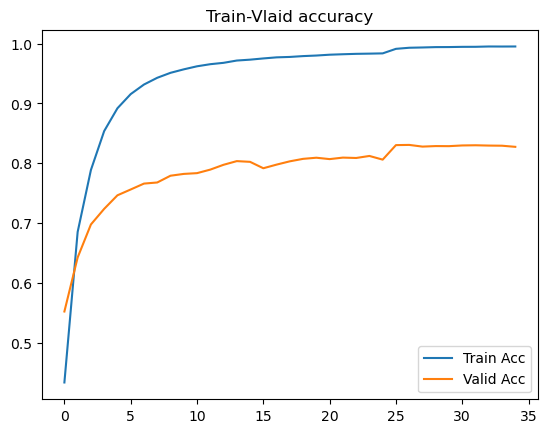

epoch 35 loss: 0.0294: 100%|████████████████| 6544/6544 [25:55<00:00,  4.21it/s]


train accuracy = 0.99536
[[2200    2    1 ...    0    0    0]
 [   0 2194    7 ...    0    0    0]
 [   0    6 2185 ...    0    0    0]
 ...
 [   0    0    0 ... 2198    2    0]
 [   0    0    0 ...    3 2196    0]
 [   0    0    0 ...    0    0 2203]]


epoch 35 loss: 0.9858: 100%|████████████████| 1860/1860 [03:19<00:00,  9.32it/s]


validation accuracy = 0.82806
[[269  10   7 ...   0   0   0]
 [  8 210  27 ...   0   1   0]
 [  3  33 404 ...   0   0   0]
 ...
 [  0   0   0 ... 159   8   0]
 [  0   0   0 ...  16 192   0]
 [  0   0   0 ...   0   0 218]]


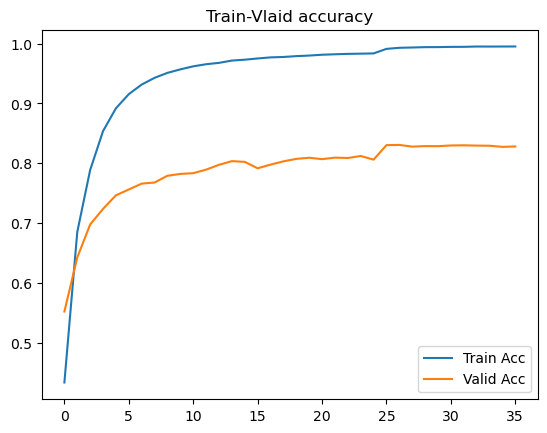

epoch 36 loss: 0.0155: 100%|████████████████| 6544/6544 [25:52<00:00,  4.22it/s]


train accuracy = 0.99539
[[2199    1    2 ...    0    0    0]
 [   2 2197    5 ...    0    0    0]
 [   3    4 2182 ...    0    0    0]
 ...
 [   0    0    0 ... 2195    4    0]
 [   0    0    0 ...    7 2193    0]
 [   0    0    0 ...    0    0 2204]]


epoch 36 loss: 0.9852: 100%|████████████████| 1860/1860 [03:20<00:00,  9.29it/s]


validation accuracy = 0.82833
[[273   5   6 ...   0   0   0]
 [  6 220  16 ...   0   1   0]
 [  1  40 411 ...   0   0   0]
 ...
 [  0   0   0 ... 163  12   0]
 [  0   0   0 ...  11 197   0]
 [  0   0   0 ...   0   0 215]]


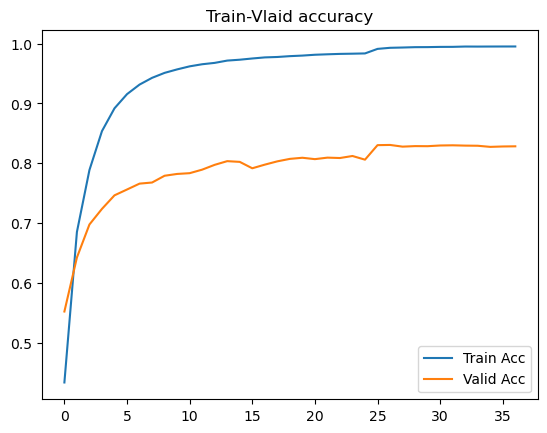

epoch 37 loss: 0.0248: 100%|████████████████| 6544/6544 [25:51<00:00,  4.22it/s]

train accuracy = 0.99543
[[2201    2    0 ...    0    0    0]
 [   1 2199    3 ...    0    0    0]
 [   1    4 2186 ...    1    0    0]
 ...
 [   0    0    0 ... 2197    5    0]
 [   0    0    0 ...    3 2197    0]
 [   0    0    0 ...    0    0 2204]]



epoch 37 loss: 0.9554: 100%|████████████████| 1860/1860 [03:19<00:00,  9.31it/s]


validation accuracy = 0.83101
[[275   8   5 ...   0   0   0]
 [  4 220  26 ...   0   1   0]
 [  4  40 413 ...   0   0   0]
 ...
 [  0   0   0 ... 160  10   0]
 [  0   0   0 ...  12 192   0]
 [  0   0   0 ...   0   0 214]]


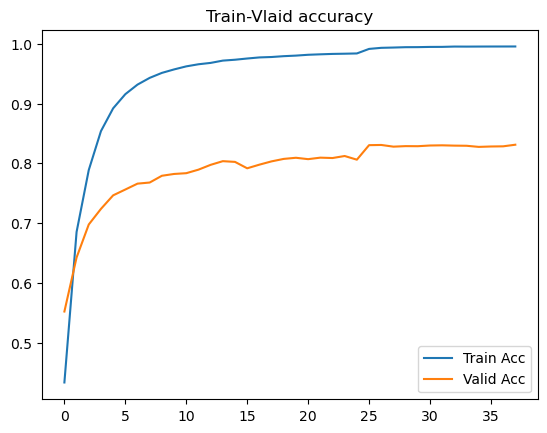

epoch 38 loss: 0.0224: 100%|████████████████| 6544/6544 [25:55<00:00,  4.21it/s]


train accuracy = 0.99562
[[2201    2    0 ...    0    0    0]
 [   1 2194    8 ...    0    0    0]
 [   0    6 2187 ...    0    0    0]
 ...
 [   0    0    0 ... 2197    5    0]
 [   0    0    0 ...    6 2194    0]
 [   0    0    0 ...    0    0 2204]]


epoch 38 loss: 1.0044: 100%|████████████████| 1860/1860 [03:19<00:00,  9.33it/s]


validation accuracy = 0.82265
[[273   6   5 ...   0   0   0]
 [  8 200  25 ...   0   1   0]
 [  4  32 387 ...   0   0   0]
 ...
 [  0   0   0 ... 170   5   1]
 [  0   0   0 ...  25 176   0]
 [  0   0   0 ...   0   0 209]]


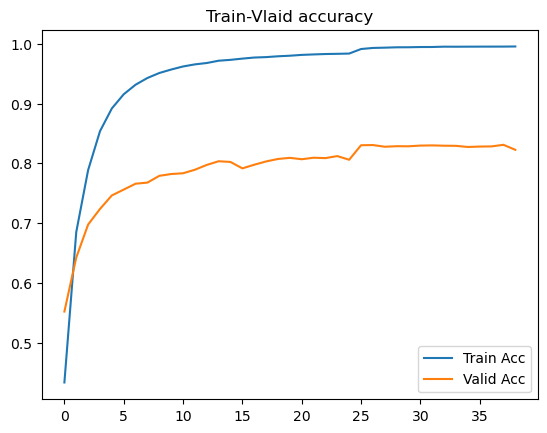

epoch 39 loss: 0.0230: 100%|████████████████| 6544/6544 [25:57<00:00,  4.20it/s]

train accuracy = 0.99587
[[2198    1    2 ...    0    0    0]
 [   3 2193    4 ...    0    0    0]
 [   1    5 2188 ...    0    0    0]
 ...
 [   0    0    0 ... 2200    2    0]
 [   0    0    0 ...    2 2196    0]
 [   0    0    0 ...    0    0 2204]]



epoch 39 loss: 1.0378: 100%|████████████████| 1860/1860 [03:20<00:00,  9.28it/s]


validation accuracy = 0.82527
[[278   7   2 ...   0   0   0]
 [  5 202  29 ...   0   1   0]
 [  3  31 396 ...   0   0   0]
 ...
 [  0   0   0 ... 160   8   0]
 [  0   0   0 ...   7 191   0]
 [  0   0   0 ...   0   0 212]]


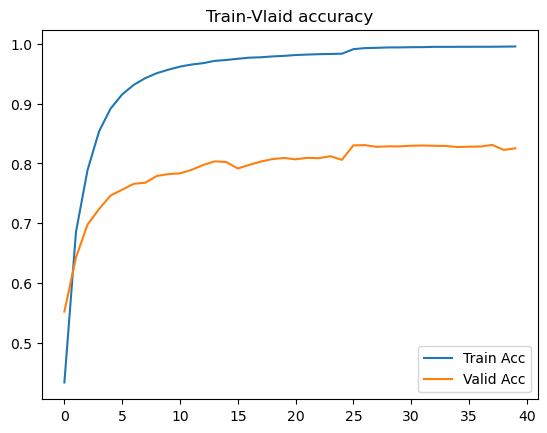

time : 19:15:26
Best Epoch : 37/ 40
Best Train Accuracy : 0.99543
[[2201    2    0 ...    0    0    0]
 [   1 2199    3 ...    0    0    0]
 [   1    4 2186 ...    1    0    0]
 ...
 [   0    0    0 ... 2197    5    0]
 [   0    0    0 ...    3 2197    0]
 [   0    0    0 ...    0    0 2204]]
Best Valid Accuracy : 0.83101
[[275   8   5 ...   0   0   0]
 [  4 220  26 ...   0   1   0]
 [  4  40 413 ...   0   0   0]
 ...
 [  0   0   0 ... 160  10   0]
 [  0   0   0 ...  12 192   0]
 [  0   0   0 ...   0   0 214]]


AttributeError: 'DataParallel' object has no attribute 'cnn_model'

AttributeError: 'DataParallel' object has no attribute 'cnn_model'

In [31]:
%run classification_train_efficientnet2.ipynb

In [18]:
print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
print(train_matrix_list[best_index])
print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
print(valid_matrix_list[best_index])

Best Epoch : 38/ 40
Best Train Accuracy : 0.99712
[[2847    3    1 ...    0    0    0]
 [   4 2849    0 ...    0    0    0]
 [   3    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    3    0]
 [   0    0    0 ...    2 2849    0]
 [   0    0    0 ...    0    0 2852]]
Best Valid Accuracy : 0.88483
[[255  10   2 ...   0   0   0]
 [  6 196   0 ...   0   0   0]
 [  3   0 389 ...   0   0   0]
 ...
 [  0   0   0 ... 178   5   0]
 [  0   0   0 ...  12 208   0]
 [  0   0   0 ...   0   0 218]]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


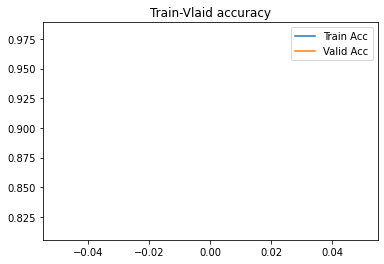

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


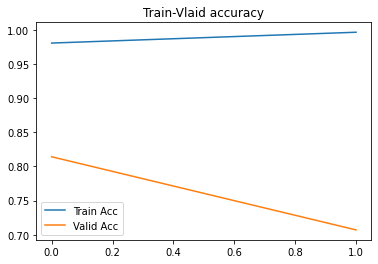

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


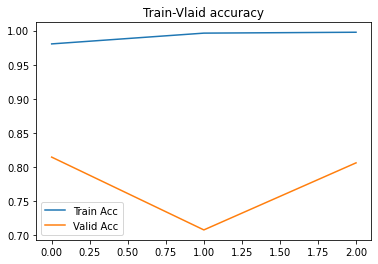

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


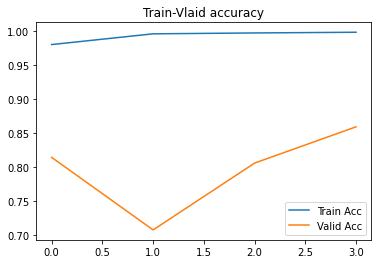

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


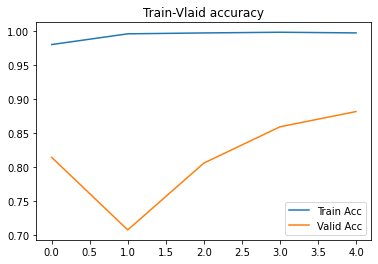

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb